# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer # Для создания Dummy из списков
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [2]:
data = pd.read_csv('main_task.xls')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [3]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [4]:
data['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [19]:
data['City'].value_counts().count()

31

In [6]:
Cuisine_Styles = pd.Series(data['Cuisine Style'].str.replace(r"(\[|]|'| '|' )",
                                                             '').str.cat(sep=',').split(',')).value_counts()

In [7]:
pd.Series(data['Cuisine Style'].fillna('1').str.cat(
    sep=',').split(',')).count()/len(data['Cuisine Style'])

2.6224

In [8]:
def get_cuisines_list(s):
    '''Используем для преобразования строки в список'''
    if bool(s):
        result = s.replace('[', '').replace(']', '').replace(
            '"', '').replace("'", '').split(', ')
    else:
        result = []
    return result

def get_dates(s, c):
    '''Используем для извлечения дат обзоров из "Reviews"'''
    result = ''
    if s!='[[], []]':
        if len(s) == 0:
            result = ''
        else:
            s = re.findall(r'\d{2}/\d{2}/\d{4}', s)
            if c == 1:
                result = s[0]
            elif len(s) == 2:
                result = s[1]
            else:
                result = ''
    return result

def get_revs(s, c):
    '''Используем для извлечения текста обзоров из "Reviews"'''
    s = re.match(r"\[\[(.*)\],", s).group()[2:-2]
    if c == 1:
        result = s
        if bool(re.search(r"\'(.*)\', ", s)):
            result = re.search(r"\'(.*)\', ", s).group()[:-2]
    else:
        result = ''
        if bool(re.search(r", [\'\"](.*)[\'\"]", s)):
            result = re.search(r", [\'\"](.*)[\'\"]", s).group()[2:]
    return result

def order_revs(row):
    '''Используем для упорядочения хронологии обзоров'''
    if bool(row.DateRev2):
        if row.DateRev2 > row.DateRev1:
            row.Rev2, row.Rev1, row.DateRev2, row.DateRev1 = row.Rev1, row.Rev2, row.DateRev1, row.DateRev2
    return row

def get_tone(s):
    '''Используем для определения тональности отзыва'''
    if pd.notna(s):
        result = sum(map(lambda word: afinn.get(word, 0),
                         re.sub(r'[^\w ]', '', s).lower().split()))
    else:
        result = s
    return result

In [9]:
# Обработка NaN
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data["Reviews_isNAN"] = pd.isna(data["Reviews"]).astype("uint8")
data["Reviews"].fillna("[[], []]", inplace=True)
data["Price_Range_isNAN"] = pd.isna(data["Price Range"]).astype("uint8")
data["Cuisine Style_isNAN"] = pd.isna(data["Cuisine Style"]).astype("uint8")

In [10]:
# Заполним пропуски Cuisine Style наиболее вероятными значениями для данного города.
tdata = data.copy()  # используем временный датафрейм для последующего "взрывания"
tdata.dropna(subset=["Cuisine Style"], inplace=True)
# Преобразуем строковые значения в список для "взрывания"
tdata['Cuisine_list'] = tdata['Cuisine Style'].apply(get_cuisines_list)
tdata = tdata.explode("Cuisine_list")
# Получим список самых популярных кухонь для каждого города
Cousine_by_city = pd.DataFrame(tdata.groupby("City")["Cuisine_list"].agg(
    pd.Series.mode))
Cousine_by_city.columns = ['Pop_city_cuisine']
Cousine_by_city=Cousine_by_city.reset_index()
# Добавим информацию о городах и кухнях в наш датафрейм
data = data.merge(Cousine_by_city, on='City', how='left')
# Заполним пропуски самым популярным значением кухни в данном городе
data['Cuisine Style'] = data['Cuisine Style'].fillna(data['Pop_city_cuisine'])
# Получим данные по кухням в виде столбца списков
data['Cuisine_list'] = data['Cuisine Style'].apply(get_cuisines_list)
# Образуем новый числовой признак - количество видов кухни в ресторане
data['Cuisines_Number'] = data['Cuisine_list'].apply(lambda x: len(x))

In [11]:
# Извлечем даты обзоров из столбца 'Reviews'
data['DateRev1'] = data['Reviews'].apply(lambda x: get_dates(x, 1))
data['DateRev2'] = data['Reviews'].apply(lambda x: get_dates(x, 2))
data['DateRev1'] = pd.to_datetime(data['DateRev1'].dropna())
data['DateRev2'] = pd.to_datetime(data['DateRev2'].dropna())

# Извлечем текст обзоров
data['Rev1'] = data['Reviews'].apply(lambda x: get_revs(x, 1))
data['Rev2'] = data['Reviews'].apply(lambda x: get_revs(x, 2))

# Расположим обзоры в хронологическом порядке
data[['Rev1', 'Rev2', 'DateRev1', 'DateRev2']] = data[[
    'Rev1', 'Rev2', 'DateRev1', 'DateRev2']].apply(order_revs, 1)

# Получим новый признак - количество дней между обзорами
data['DateDelta'] = (data['DateRev1']-data['DateRev2']).dt.days

# Обработаем пропуски с сохранением информации о них
data['DateDelta_isNAN'] = pd.isna(data['DateDelta']).astype("uint8")
data['DateDelta'].fillna(data['DateDelta'].dropna().median(), inplace=True)

# Определим актуальность отзывов относительно самого свежего встречаемого в базе.
last_date = data[['DateRev1', 'DateRev2']].max().max()
data['Isuptodate'] = (last_date-data['DateRev1']).dt.days
data['Isuptodate'].fillna(data['Isuptodate'].dropna().median(), inplace=True)

# Добавим информацию о количестве видов кухни в разных городах в наш датафрейм
Cuisines_num_by_city = data.explode("Cuisine_list").groupby(
    "City")["Cuisine_list"].unique().apply(len).to_frame().reset_index()
Cuisines_num_by_city.columns = ['City', 'Cuisines_num_by_city']
data = data.merge(Cuisines_num_by_city, on='City', how='left')

# Добавим информацию о медиане отзывов по городам в наш датафрейм для заполнения пропусков в 'Number of Reviews'
Reviews_num_by_city = data.dropna(subset=['Number of Reviews']).groupby(
    "City")['Number of Reviews'].median().to_frame().reset_index()
Reviews_num_by_city.columns = ['City', 'Reviews_num_by_city']
data = data.merge(Reviews_num_by_city, on='City', how='left')
# Заполним пропуски 'Number of Reviews' значениями медианы отзывов по городам
data['Number of Reviews'].fillna(data['Reviews_num_by_city'], inplace=True)

In [12]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
cities_encoded = pd.get_dummies(data, columns=['City'])
data = pd.concat([data['City'], cities_encoded], axis=1)

In [13]:
# Закодируем признак 'Cuisine Style' в dummy значения

mlb = MultiLabelBinarizer()
cuisines_encoded = pd.DataFrame(mlb.fit_transform(
    data['Cuisine_list']), columns=mlb.classes_).astype("uint8")
data = pd.concat([data, cuisines_encoded], axis=1)

In [14]:
data["Price Range"].fillna(data["Price Range"].mode()[0], inplace=True)
data['Price Range'] = data['Price Range'].replace(
    ['$', '$$ - $$$', '$$$$'], [1, 2, 3])

In [15]:
# Получим оценку тональности отзывов в качестве нового признака
# Загрузим словарь для определения настроения отзывов (http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html)
# Каждое слово словаря имеет оценку (-5:+5). Фраза оценивается как сумма оценок слов. 
afinn = {}
with open("AFINN-111.txt") as file:
    for line in file:
        key, *value = line.split('\t')
        afinn[key] = int(value[0].replace('\n', ''))
# Рассчитаем тональности отзывов.        
data['Rev1_tone'] = data['Rev1'].apply(get_tone)
data['Rev2_tone'] = data['Rev2'].apply(get_tone)  
# Обработаем пропуски
data['Rev2_tone'].fillna(data['Rev1_tone'], inplace=True)
Rev_tones_mode = data['Rev1_tone'].mode()[0]
data['Rev1_tone'].fillna(Rev_tones_mode, inplace=True)
data['Rev2_tone'].fillna(Rev_tones_mode, inplace=True)

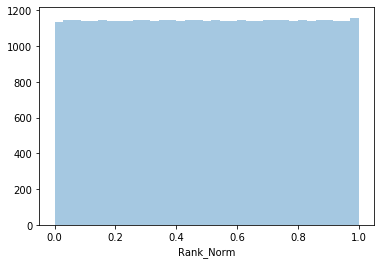

In [16]:
# Нормализуем 'Ranking' для каждого города и добавим новый признак в датафрейм
data['Rank_Norm'] = data.groupby('City')['Ranking'].rank(pct=True)
sns.distplot(data["Rank_Norm"], kde=False)
plt.show()

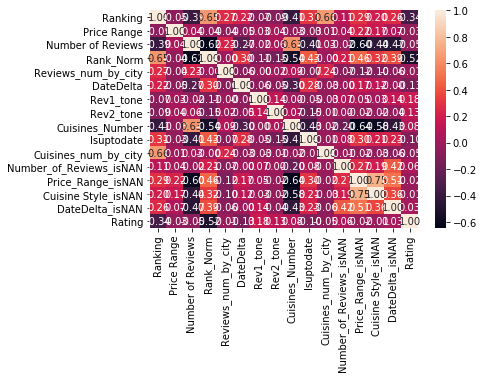

In [17]:
# Для построения диаграммы корреляций используем только числовые и ранговые признаки
cols = ['City', 'Ranking', 'Price Range', 'Number of Reviews', 'Rank_Norm',
        'Reviews_num_by_city', 'DateDelta',
        'Rev1_tone', 'Rev2_tone', 'Cuisines_Number', 'Isuptodate',
        'Cuisines_num_by_city', 'Number_of_Reviews_isNAN', 
        'Price_Range_isNAN', 'Cuisine Style_isNAN', 'DateDelta_isNAN', 'Rating']
corr = data[cols].corr(method="spearman")

sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [18]:
np.abs(corr["Rating"].drop("Rating")).sort_values(ascending=False)

Rank_Norm                  0.516386
Ranking                    0.341748
Rev1_tone                  0.175246
Rev2_tone                  0.130226
DateDelta                  0.126880
Isuptodate                 0.099405
Cuisines_Number            0.076335
Number_of_Reviews_isNAN    0.063881
Number of Reviews          0.054817
Cuisines_num_by_city       0.046771
Price Range                0.034555
DateDelta_isNAN            0.034467
Price_Range_isNAN          0.020953
Reviews_num_by_city        0.011475
Cuisine Style_isNAN        0.009511
Name: Rating, dtype: float64

In [23]:
data.drop(['DateRev1','DateRev2'], axis = 1, inplace=True)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)
#data = data.convert_dtypes()

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [25]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data.drop(['Rating'], axis=1)
y = data['Rating']

In [72]:
#X = X.select_dtypes(exclude='object')

In [74]:
#X.columns = ['rank', 'revs_num']
#values = {'rank': X['rank'].mean(), 'revs_num': X['revs_num'].mean()}
#X.fillna(value=values, inplace=True)

In [26]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [27]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [28]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [29]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [80]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2003665
